<b>Цель проекта</b> —  построить модель, предсказывающую снижение покупательской активности, и провести сегментацию клиентов для персонализированных предложений, основываясь на поведении и прибыльности.
<br>
Необоходимо провести предобработку, анализ, масштабирование и кодирование предоставленных данных. После этого обучить четыре модели и выбрать лучшую, на основании неё построить прогноз. Обучение моделей должно быть реализовано посредством пайплайнов.
<br><br>
<b>Описание данных:</b>
<br><br>
market_file.csv
<br>
Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
    id — номер покупателя в корпоративной базе данных.<br>
    Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».<br>
    Тип сервиса — уровень сервиса, например «премиум» и «стандарт».<br>
    Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.<br>
    Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
    Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.<br>
    Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.<br>
    Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.<br>
    Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.<br>
    Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.<br>
    Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.<br>
    Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.<br>
    Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.
<br>
<br>
	market_money.csv<br>
Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.<br>
    id — номер покупателя в корпоративной базе данных.<br>
    Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.<br>
    Выручка — сумма выручки за период.<br>
<br>
market_time.csv<br>
Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.<br>
    id — номер покупателя в корпоративной базе данных.<br>
    Период — название периода, во время которого зафиксировано общее время.<br>
    минут — значение времени, проведённого на сайте, в минутах.<br>
<br>
money.csv<br>
Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.<br>
    id — номер покупателя в корпоративной базе данных.<br>
    Прибыль — значение прибыли.<br>
<br>
<b>План работ</b><br>
1. Загрузка и изучение данных (парсинг, нейминг столбцов)
2. Предобработка данных (явные и неявные дубликаты, пропуски)
3. Исследовательский анализ данных (описание данных, статистических анализ всех признаков с гистограммами для количественных и столбчатами/круговыми диаграммами для качественных признаков, выбросы, рекомендации по улучшению данных, их применение)
4. Объединение таблиц (market_file.csv, market_money.csv, market_time.csv)
5. Корреляционный анализ признаков в датасете market_main.csv (диаграмма рассеяния, матрица корреляции)
6. Использование пайплайнов (для моделей KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC())
7. Анализ важности признаков (с помощью метода SHAP)
8. Сегментация покупателей (графическое и аналитическое исследование группы покупателей)
9. Итоговые выводы

<h2>Загрузка и изучение данных</h2>

In [1]:
!pip install matplotlib==3.5.0 -q

In [2]:
!pip install shap -q

In [3]:
pip install -U scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import shap
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

from sklearn.impute import SimpleImputer

from itertools import chain

Для удобства загрузки воспользуемся кастомной функцией

In [5]:
def load_dataset(filepath, sep=';'):
    """
    Загружает CSV-файл и возвращает DataFrame.
    Обрабатывает ошибки FileNotFound и другие исключения.
    
    Параметры:
    - filepath (str): путь к файлу
    - sep (str): разделитель в CSV (по умолчанию ';')
    
    Возвращает:
    - DataFrame при успешной загрузке, иначе None
    """
    try:
        df = pd.read_csv(filepath, sep=sep)
        print(df.head(5))
        return df
    except FileNotFoundError:
        print(f"Ошибка: Файл '{filepath}' не найден по указанному пути.")
    except Exception as e:
        print(f"Произошла непредвиденная ошибка при загрузке файла '{filepath}': {e}")
    return None

In [6]:
data_market = load_dataset('/datasets/market_file.csv', ',')

       id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей             

In [7]:
data_market_money = load_dataset('/datasets/market_money.csv', ',')

       id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6


In [8]:
data_market_time = load_dataset('/datasets/market_time.csv', ',')

       id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13


In [9]:
data_money = load_dataset('/datasets/money.csv')

       id Прибыль
0  215348    0,98
1  215349    4,16
2  215350    3,13
3  215351    4,87
4  215352    4,21


Всего для анализа предоставленно четыре датасета, приведём названия столбцов для каждого из них к единому виду и строчному написанию

In [10]:
data_market.columns = data_market.columns.str.lower().str.replace(' ', '_')
data_market.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

In [11]:
data_market_time = data_market_time.rename(columns={
    'минут': 'количество_минут'
})
data_market_time.columns = data_market_time.columns.str.lower()
data_market_time.columns

Index(['id', 'период', 'количество_минут'], dtype='object')

In [12]:
data_market_money.columns = data_market_money.columns.str.lower()
data_market_money.columns

Index(['id', 'период', 'выручка'], dtype='object')

In [13]:
data_money.columns = data_money.columns.str.lower()
data_money.columns

Index(['id', 'прибыль'], dtype='object')

После загрузки данных с использованием соответствующего ращделителя стало видно, что данные соответсвует заявленным. Провели корректировку названий столбцов, заменив пробелы на ниижнее подчёркивание

<h2>Предобработка данных</h2>

Посмотрим, данные какого типа представлены в каждом из датасетов

In [14]:
data_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [15]:
data_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [16]:
data_market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                2600 non-null   int64 
 1   период            2600 non-null   object
 2   количество_минут  2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [17]:
data_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


Типы данных в первых трёх датасетах корректны и соответствуют хранящимся данным. В четвёртом датасете необходимо привести столбец Прибыль к типу float64

In [18]:
for col in data_money.columns:
        if data_money[col].dtype == 'object':
            data_money[col] = data_money[col].str.replace(',', '.').astype(float)
data_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Проверим каждый из датасестов на наличие пропусков и дубликатов

In [19]:
data_market_missing = data_market.isna().sum()
data_market_time_missing = data_market_time.isna().sum()
data_market_money_missing = data_market_money.isna().sum()
data_money_missing = data_money.isna().sum()
print('Количество пропусков в data_market: {:}, в data_market_time: {:} в data_market_money: {:} в data_money: {:}'.format(data_market_missing,
                                                                                                                           data_market_time_missing,
                                                                                                                           data_market_money_missing,
                                                                                                                           data_money_missing))

Количество пропусков в data_market: id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64, в data_market_time: id                  0
период              0
количество_минут    0
dtype: int64 в data_market_money: id         0
период     0
выручка    0
dtype: int64 в data_money: id         0
прибыль    0
dtype: int64


Пропусков нет, хорошо. Посмотрим есть ли дубликаты

In [20]:
data_market_dupl = data_market.duplicated().sum()
data_market_time_dupl = data_market_time.duplicated().sum()
data_market_money_dupl = data_market_money.duplicated().sum()
data_money_dupl = data_money.duplicated().sum()
print('Количество дубликатов в data_market: {:}, в data_market_time: {:} в data_market_money: {:} в data_money: {:}'.format(data_market_dupl,
                                                                                                                           data_market_time_dupl,
                                                                                                                           data_market_money_dupl,
                                                                                                                           data_money_dupl))

Количество дубликатов в data_market: 0, в data_market_time: 0 в data_market_money: 0 в data_money: 0


Явных дубликатов тоже нет, хорошее качество данных. Посмотрим неявные дубликаты для строковых значений в каждом из датасетов, начнём с data_market

In [21]:
unique_id = data_market['id'].value_counts()
unique_id

215348    1
216202    1
216220    1
216219    1
216218    1
         ..
215779    1
215778    1
215777    1
215776    1
216647    1
Name: id, Length: 1300, dtype: int64

In [22]:
unique_bying_activity = data_market['покупательская_активность'].value_counts()
unique_bying_activity 

Прежний уровень    802
Снизилась          498
Name: покупательская_активность, dtype: int64

In [23]:
unique_service_type = data_market['тип_сервиса'].value_counts()
unique_service_type 

стандарт     914
премиум      376
стандартт     10
Name: тип_сервиса, dtype: int64

Есть неявный дубликат для типа стандарт, приведём данные к одному виду. Перед тем как изменять данные, сделаем копию

In [24]:
len(data_market)

1300

In [25]:
temp_data_market = data_market.copy() # создаем копию датасета до преобразования
len(temp_data_market)

1300

In [26]:
temp_data_market['тип_сервиса'] = (
    temp_data_market['тип_сервиса']
    .str.strip()
    .str.lower()
    .replace({'стандартт': 'стандарт'})
)
# Проверим результат
unique_service_type = temp_data_market['тип_сервиса'].value_counts()
unique_service_type

стандарт    924
премиум     376
Name: тип_сервиса, dtype: int64

In [27]:
unique_agree = temp_data_market['разрешить_сообщать'].value_counts()
unique_agree

да     962
нет    338
Name: разрешить_сообщать, dtype: int64

In [28]:
unique_popular_cat = temp_data_market['популярная_категория'].value_counts()
unique_popular_cat

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: популярная_категория, dtype: int64

Исправим опечатку в категории Косметика и аксесуары

In [29]:
temp_data_market['популярная_категория'] = (
    temp_data_market['популярная_категория']
    .str.strip()
    .str.lower()
    .replace({'косметика и аксесуары': 'косметика и аксессуары'})
)
# Проверим результат
unique_popular_cat = temp_data_market['популярная_категория'].value_counts()
unique_popular_cat

товары для детей                        330
домашний текстиль                       251
косметика и аксессуары                  223
техника для красоты и здоровья          184
мелкая бытовая техника и электроника    174
кухонная посуда                         138
Name: популярная_категория, dtype: int64

Таким образом в датасете data_market был найден один неявный дубликат в Типе сервиса, он был скорректирован. Остальные столбцы датасета не содержат неявных дубликатов, перейдём к data_market_money

In [30]:
unique_timeframe = data_market_money['период'].value_counts()
unique_timeframe

предыдущий_месяц       1300
текущий_месяц          1300
препредыдущий_месяц    1300
Name: период, dtype: int64

Нейминг препредыдущий_месяц немного сбивает. Можно переименовать в два месяца назад.  Перед тем как изменять данные, сделаем копию

In [31]:
len(data_market_money)

3900

In [32]:
temp_data_market_money = data_market_money.copy() # создаем копию датасета до преобразования
len(temp_data_market_money)

3900

In [33]:
temp_data_market_money['период'] = (
    temp_data_market_money['период']
    .str.strip()
    .str.lower()
    .replace({'препредыдущий_месяц': 'два_месяца_назад'})
)
# Проверим результат
unique_timeframe = temp_data_market_money['период'].value_counts()
unique_timeframe

предыдущий_месяц    1300
два_месяца_назад    1300
текущий_месяц       1300
Name: период, dtype: int64

In [34]:
unique_timeframe = data_market_time['период'].value_counts()
unique_timeframe

текущий_месяц       1300
предыдцщий_месяц    1300
Name: период, dtype: int64

Здесь допущена опечатка в значении предыдцщий_месяц, исправим для консистентности данных

In [35]:
len(data_market_time)

2600

In [36]:
temp_data_market_time = data_market_time.copy() # создаем копию датасета до преобразования
len(temp_data_market_time)

2600

In [37]:
temp_data_market_time['период'] = (
    temp_data_market_time['период']
    .str.strip()
    .str.lower()
    .replace({'предыдцщий_месяц': 'предыдущий_месяц'})
)
# Проверим результат
unique_timeframe = temp_data_market_time['период'].value_counts()
unique_timeframe

предыдущий_месяц    1300
текущий_месяц       1300
Name: период, dtype: int64

Итого были скорректированы значения в столбце Период для датасетов data_market_money, data_market_time

В результате предобработки данных названия столбцов были приведены к единому виду. Данные каждого из датасетов были проверены на наличие явных дубликатов и пропусков, их обнаружено не было <br>
Был найден один неявный дубликат в столбце Тип_сервиса и несколько опечаток, их исправили <br>
Датасеты data_market, data_market_money, data_market_time можно объединить по id

<h2>Исследовательский анализ данных</h2>

В рамках исследовательского анализа данных проведём статистический анализ всех признаков и построим гафики для каждого признака, при этом будем учитывать, что покупательская активность клиентов должна быть не менее трёх месяцев
Для удобства разделим все признаки на качественные и количественные<br>
Разделим признаки для data_market<br>
К количественным у нас будут относится<br>
'Маркет_актив_6_мес', 'Длительность', 'Акционные_покупки', 'Страниц_за_визит', 'маркет_актив_тек_мес'
к дискретным 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'маркет_актив_тек_мес'<br>
а к качественным (категориальным)<br>
'Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать', 'Популярная_категория'<br>

In [38]:
# Разделим признаки по типу
quantitative_features = [
    'маркет_актив_6_мес', 'длительность', 'акционные_покупки', 'страниц_за_визит'
]
categorical_features = [
    'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория'
]

discrete_features = [
    'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'маркет_актив_тек_мес'
]

<div class="alert alert-info"> <b>Комментарии студентаV1: </b>упс, не учла, спасибо, Марат, исправила</div>

In [39]:
# Статистическое описание количественных признаков
temp_data_market[quantitative_features].describe()

,маркет_актив_6_мес,длительность,акционные_покупки,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000
mean,4.253769,601.898462,0.319808,8.176923
std,1.014814,249.856289,0.249843,3.978126
min,0.900000,110.000000,0.000000,1.000000
25%,3.700000,405.500000,0.170000,5.000000
50%,4.200000,606.000000,0.240000,8.000000
75%,4.900000,806.000000,0.300000,11.000000
max,6.600000,1079.000000,0.990000,20.000000


Перейдём к построению графиков для количественных признаков. Для этого создадим функцию, которая построит гистограмму и ящик с усами

In [40]:
# Функция для отрисовки графиков количественного признака
def plot_quantitative_feature(df, feature):
    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(df[feature], bins=30, kde=True)
    plt.title(f'Гистограмма: {feature}')
    plt.xlabel(feature)
    plt.ylabel('Количество')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[feature])
    plt.title(f'Ящик с усами: {feature}')
    plt.xlabel(feature)

    plt.tight_layout()
    plt.show()

Посторим диаграммы для каждого из признаков

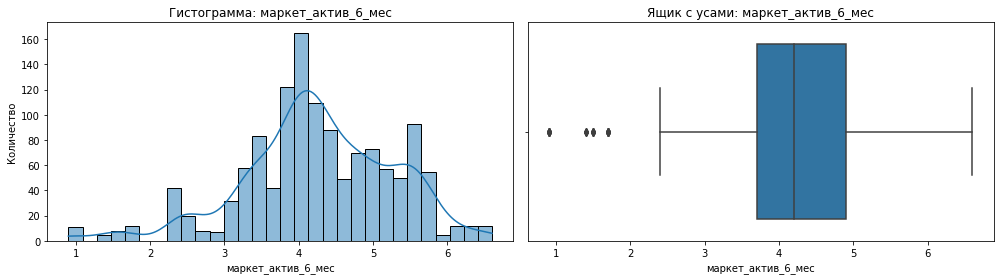

In [41]:
plot_quantitative_feature(temp_data_market, 'маркет_актив_6_мес')

Среднемесячное количество маркетинговых касаний содержит вбросы до 2.5 месяцев. В среднем количество какасний составляет 4.25 в месяц за последние пол года

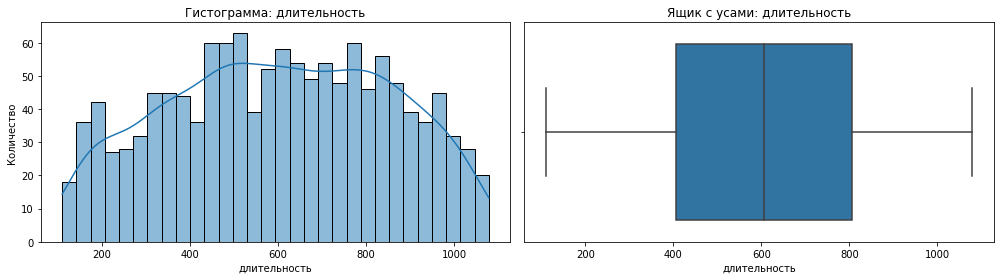

In [42]:
plot_quantitative_feature(temp_data_market, 'длительность')

Длительность с момента регистрации клиентов на сайте составляет в среднем 600 дней, распределение практически равномерное, без выбросов

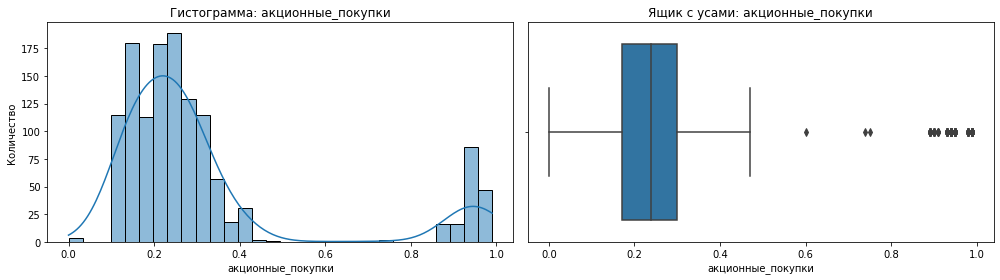

In [43]:
plot_quantitative_feature(temp_data_market, 'акционные_покупки')

В среднемесячной доли покупок по акции от общего числа покупок за последние 6 месяцев заметоно болльшое количество вбросов после 0.5
Возможно, стоит рассматривать клиентов с акциями и без как отдельные подгруппы, если мы хотим сегментировать клиентов, чтобы вводить для них персонализированные предложения.
В таком случае стоит ввести новый столбец, который будет указывать, что среди покупок клиента преобладают акционные (temp_data_market['Акционные_покупки'] > 0.5)

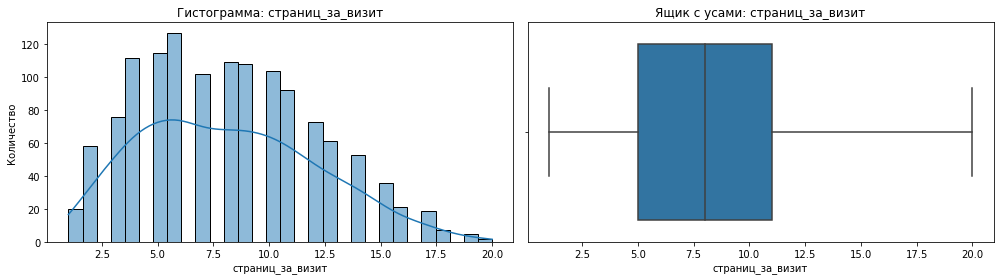

In [44]:
plot_quantitative_feature(temp_data_market, 'страниц_за_визит')

В среднем пользователь просматривает порядка 8 страниц за один визит за последние три месяца

Построим графики для дискретных признаков

In [45]:
def plot_discrete_feature(df, feature):
    plt.figure(figsize=(14, 4))
    # количество наблюдений по значениям
    plt.subplot(1, 2, 1)
    sns.countplot(x=feature, data=df, order=sorted(df[feature].unique()))
    plt.title(f'Столбчатый-график: {feature}')
    plt.xlabel(feature)
    plt.ylabel('Количество')
    plt.show()

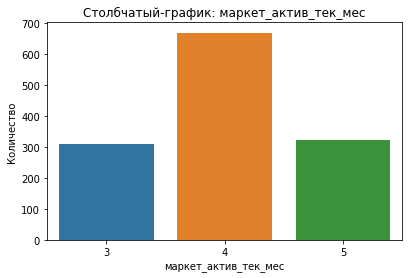

In [46]:
plot_discrete_feature(temp_data_market, 'маркет_актив_тек_мес')

Наибольшее количество клиентов (свыше 600) получили 4 маркетинговых активности в текущем месяце

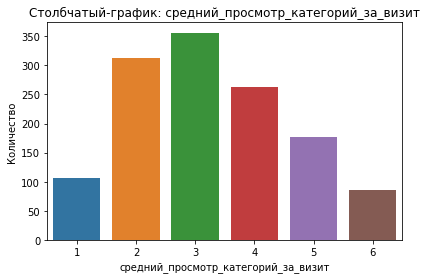

In [47]:
plot_discrete_feature(temp_data_market, 'средний_просмотр_категорий_за_визит')

Свыше 350 клиентов просматривают 3 категории за визит, минимум — олну, макимум шесть (минимальные и максимальные значения встречаются у меньшего количества человек, в районе ста)

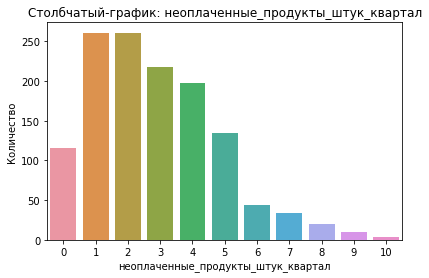

In [48]:
plot_discrete_feature(temp_data_market, 'неоплаченные_продукты_штук_квартал')

Общее количество неоплаченных товаров в корзине за последние три месяца стремится к нулю, но есть редкие клиенты у которых не оплачено 8 и более товаров. Среднее значение составляет 2.8, есть немного выбросов после 8 товаров.

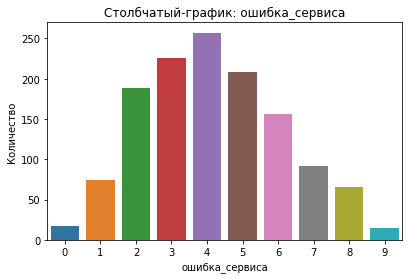

In [49]:
plot_discrete_feature(temp_data_market, 'ошибка_сервиса')

Число сбоев, которые коснулись покупателя во время посещения сайта в среднем составляет 4. На большинство клиентов приходится от 4 до 6 сбоев в системе за время посещения сайта

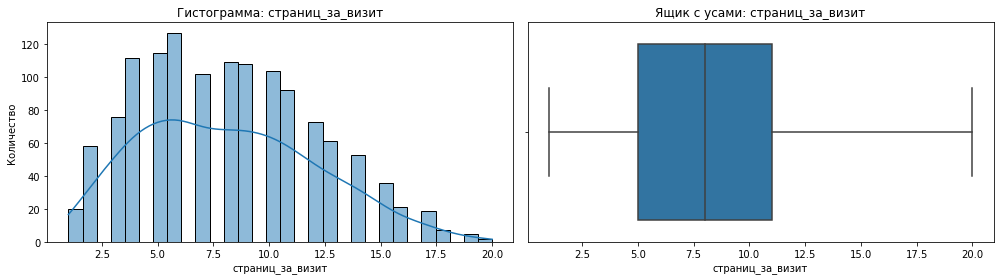

In [50]:
plot_quantitative_feature(temp_data_market, 'страниц_за_визит')

В среднем пользователь просматривает порядка 8 страниц за один визит за последние три месяца

Теперь построим графики для категориальных признаков

In [51]:
def plot_categorical_feature(df, feature):
    plt.figure(figsize=(12, 5))

    # Bar plot
    plt.subplot(1, 2, 1)
    sns.countplot(x=feature, data=df, order=df[feature].value_counts().index)
    plt.title(f'Столбчатая диаграмма: {feature}')
    plt.xlabel(feature)
    plt.ylabel('Количество')
    plt.xticks(rotation=30)

    # Pie chart
    plt.subplot(1, 2, 2)
    df[feature].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
    plt.title(f'Круговая диаграмма: {feature}')
    plt.ylabel('')

    plt.tight_layout()
    plt.show()

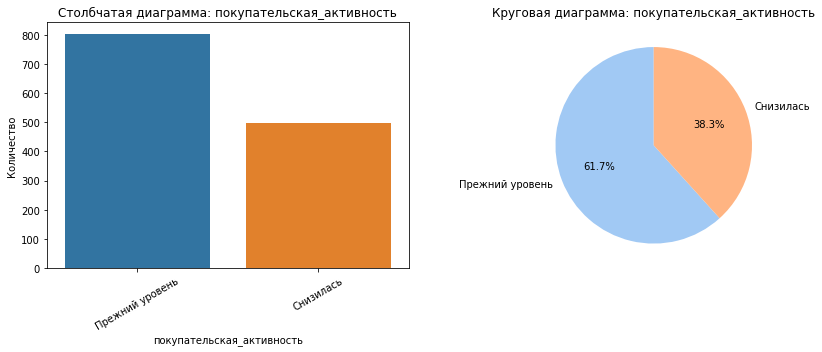

In [52]:
plot_categorical_feature(temp_data_market, 'покупательская_активность')

Покупательская активность (целевой признак) для большинства клиентов осталась на преженм уровне (61.7%, 800 человек)

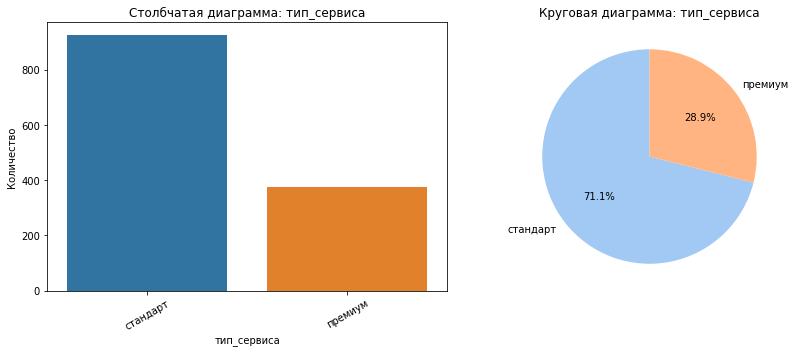

In [53]:
plot_categorical_feature(temp_data_market, 'тип_сервиса')

Абсолютное большинство клиентов пользуется стандартным сервисом (71.1%), в то время как премиумом пользутся 28.9% клиентов

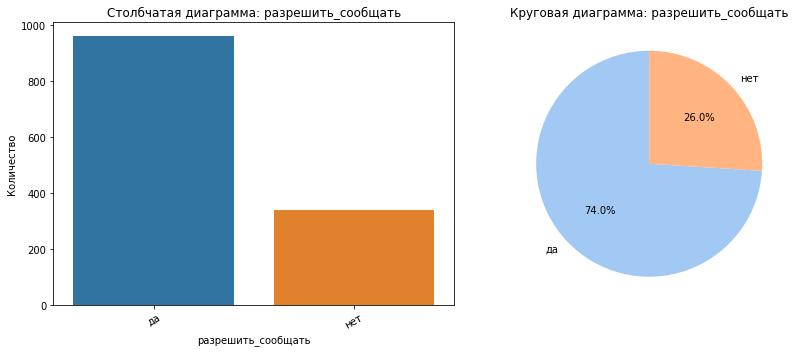

In [54]:
plot_categorical_feature(temp_data_market, 'разрешить_сообщать')

Большинство покупателей (74%) дало согласие на участие в рассылке дополнительных предложений о товаре. Отказались 26% (менее 400 человек)

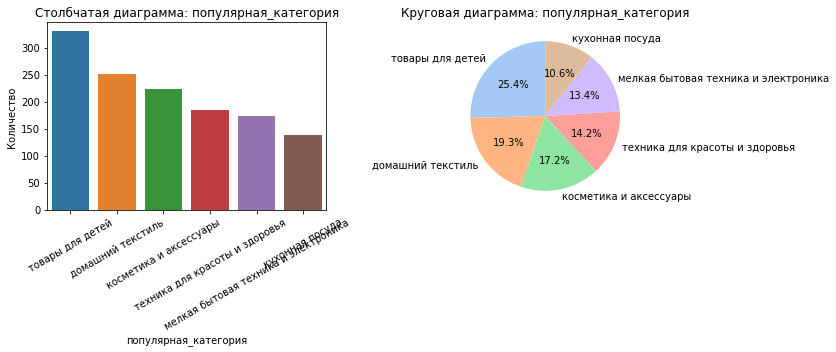

In [55]:
plot_categorical_feature(temp_data_market, 'популярная_категория')

Наибольшим спросом пользуются товары для детей, затем косметика и аксессуары, а а меньший интерес среди покупателей вызывает кухонная посуда

Отлично, исследовательский анализ датасета temp_data_market закончен, перейдём к temp_data_market_money

In [56]:
# Статистическое описание количественных признаков
temp_data_market_money['выручка'].describe()

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64

Посмотрим на зависимости между выручкой и количеством минут, проведённых на сайте

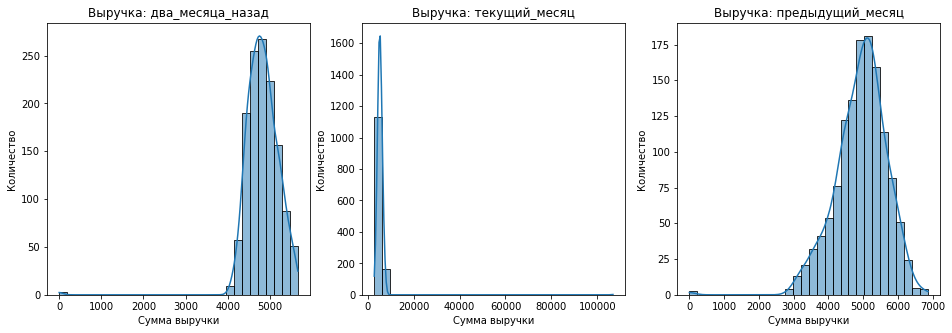

In [57]:
# Список уникальных периодов
periods = temp_data_market_money['период'].unique()

# Создаём графики
plt.figure(figsize=(16, 5))

for i, period in enumerate(periods):
    plt.subplot(1, len(periods), i + 1)
    subset = temp_data_market_money[temp_data_market_money['период'] == period]
    sns.histplot(subset['выручка'], bins=30, kde=True)
    plt.title(f'Выручка: {period}')
    plt.xlabel('Сумма выручки')
    plt.ylabel('Количество')

У выручки за предыдущие периоды распределение равномерное, выбросов практически нет, все клиенты приносят примерно одинаковую прибыль.Медианная вырручка составляет 5000, оснавная масса значений сосредоточена до 10000
Но в графике выручки за текущий месяц наблюдается аномалия — выбросы свыше 100000, и у многих клиентов выручка 0, похоже на сбой.
Анамальные выбросы удалим
Каждый клиент встречается в таблице 3 раза, по одному на каждый месяц, перед объединением необходимо преобразовать таблицу к pivot

Возьмём данные за текущий период и удалим выбросы, чтобы модель при обучении не подстраивалась под них

In [58]:
temp_data_market_money = temp_data_market_money[temp_data_market_money['выручка'] < 100_000]
temp_data_market_money['выручка'].describe()

count    3899.00000
mean     4999.57743
std       706.99988
min         0.00000
25%      4590.10000
50%      4957.00000
75%      5363.00000
max      7799.40000
Name: выручка, dtype: float64

<div class="alert alert-info"> <b>Комментарии студентаV1: </b>Очень информативно получилось, спасибо, не додумалась, учту, круто, респект!</div>

Исследовательский анализ датасета temp_data_market_money закончен, перейдём к data_market_time

In [59]:
# Статистическое описание количественных признаков
temp_data_market_time['количество_минут'].describe()

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: количество_минут, dtype: float64

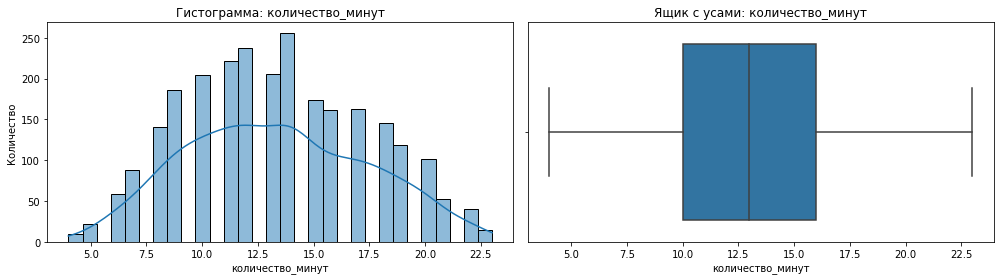

In [60]:
plot_quantitative_feature(temp_data_market_time, 'количество_минут')

В среднем пользователи проводят порядка 13 минут на сайте за одну сессию, есть небольшое количество клиентов, у которых время сессии меньше пяти минут, а также те которые проводят больше 22х минут

Для проведения исследовательского анализа данных мы выделили категориальные и количественные признаки. Построили гистограммы и ящики с усами для количественных признаков, чтобы визуализировать распределение данных.Затем построили столбчатые и круговые диаграммы для качественных признаков.<br>
<br>
<b>В результате исследовательского анализа данных были выявлены следующие особенности:</b><br>
Среднемесячное количество маркетинговых касаний содержит вбросы до 2.5 месяцев. В среднем количество какасний составляет 4.25 в месяц за последние пол года<br>
Количество маркетинговых коммуникаций лучше рассматривать как категориальный, а не количественный признак<br>
Длительность с момента регистрации клиентов на сайте составляет в среднем 600 дней, распределение практически равномерное, без выбросов<br>
В среднемесячной доли покупок по акции от общего числа покупок за последние 6 месяцев заметоно болльшое количество вбросов после 0.5<br>
Возможно, стоит рассматривать клиентов с акциями и без как отдельные подгруппы, если мы хотим сегментировать клиентов, чтобы вводить для них персонализированные предложения.
В таком случае стоит ввести новый столбец, который будет указывать, что среди покупок клиента преобладают акционные (temp_data_market['Акционные_покупки'] > 0.5)<br>
В среднем покупатель просмотрел за визит в течение последнего месяца около 3х категорий, но есть такие покупатели, которые просмотрели 6, а минимум — одна категория. Выбросов нет<br>
Общее количество неоплаченных товаров в корзине за последние три месяца стремится к нулю, но есть редкие клиенты у которых не оплачено 8 и более товаров. Среднее значение составляет 2.8, есть немного выбросов после 8 товаров.<br>
Число сбоев, которые коснулись покупателя во время посещения сайта в среднем составляет 4. На большинство клиентов приходится от 4 до 6 сбоев в системе за время посещения сайта
<br>
В среднем пользователь просматривает порядка 8 страниц за один визит за последние три месяца<br>
Среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев, для большинства покупателей составляет 4 (51%)
По 3 и 5 коммуникаций получило примерно одинаковое количество пользователей (чуть больше 300)<br>
Покупательская активность (целевой признак) для большинства клиентов осталась на преженм уровне (61.7%, 800 человек)<br>
Абсолютное большинство клиентов пользуется стандартным сервисом (71.1%), в то время как премиумом пользутся 28.9% клиентов<br>
Большинство покупателей (74%) дало согласие на участие в рассылке дополнительных предложений о товаре. Отказались 26% (менее 400 человек)<br>
Наибольшим спросом пользуются товары для детей, затем косметика и аксессуары, а а меньший интерес среди покупателей вызывает кухонная посуда<br>
У выручки за предыдущие периоды распределение равномерное, выбросов практически нет, все клиенты приносят примерно одинаковую прибыль.Медианная вырручка составляет 5000, оснавная масса значений сосредоточена до 10000<br>
Но в графике выручки за текущий месяц наблюдается аномалия — выбросы свыше 100000, и у многих клиентов выручка 0, похоже на сбой.<br>
Анамальные выбросы удалим<br>
В среднем пользователи проводят порядка 13 минут на сайте за одну сессию, есть небольшое количество клиентов, у которых время сессии меньше пяти минут, а также те которые проводят больше 22х минут<br>

<h2>Объединение таблиц</h2>

Для удобства работы объединим данные из трёх датасетов market_file.csv, market_money.csv, market_time.csv в одиин, по столбцу id. Примем ко вниманию тот факт, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделаем отдельный столбец для каждого периода.

Перед объединением развернём таблицы для market_money.csv, market_time.csv с помощью pivot

In [61]:
pivot_market_money = temp_data_market_money.pivot(index='id', columns='период', values='выручка')
pivot_market_money.columns = [f'выручка_{col}' for col in pivot_market_money.columns]
pivot_market_money = pivot_market_money.reset_index()
pivot_market_money.head(5)

,id,выручка_два_месяца_назад,выручка_предыдущий_месяц,выручка_текущий_месяц
0,215348,0.0,0.0,3293.1
1,215349,4472.0,5216.0,4971.6
2,215350,4826.0,5457.5,5058.4
3,215351,4793.0,6158.0,6610.4
4,215352,4594.0,5807.5,5872.5


In [62]:
pivot_market_time = temp_data_market_time.pivot(index='id', columns='период', values='количество_минут')
pivot_market_time.columns = [f'количество_минут_{col}' for col in pivot_market_time.columns]
pivot_market_time = pivot_market_time.reset_index()
pivot_market_time.head(5)

,id,количество_минут_предыдущий_месяц,количество_минут_текущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


Теперь объединим датасеты по айди используя left тк все основные данные хранятся в market_file и в двух вспомогательных файлах может не быть каких-то id

In [63]:
final_df = temp_data_market.merge(pivot_market_money, on='id', how='left')
final_df = final_df.merge(pivot_market_time, on='id', how='left')
final_df.head(10)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_два_месяца_назад,выручка_предыдущий_месяц,выручка_текущий_месяц,количество_минут_предыдущий_месяц,количество_минут_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10
6,215354,Снизилась,стандарт,да,5.1,3,431,0.23,косметика и аксессуары,2,3,7,2,4503.0,5685.0,5869.6,11,12
7,215355,Снизилась,стандарт,нет,4.7,4,284,0.17,товары для детей,5,1,6,4,4749.0,3263.0,3772.6,12,10
8,215356,Снизилась,стандарт,да,4.2,4,192,0.14,косметика и аксессуары,2,2,1,3,4433.0,4146.5,4566.4,6,7
9,215357,Снизилась,стандарт,да,3.9,5,154,0.00,техника для красоты и здоровья,3,3,9,5,0.0,0.0,5986.3,12,6


Для корректного обучения моделей необоходимо отобрать клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период, для того чтобы модель ошибочно не приняла клиентов с нулевой выручкой за тех, чья активность снизилась.
Это обусловлено тем, что такие клиенты могли уйти и тем что их сложно итерпретировать — мы не знаем утеряны они или потенциально активны

In [64]:
final_df = final_df[
    (final_df['выручка_текущий_месяц'] > 0) &
    (final_df['выручка_предыдущий_месяц'] > 0) &
    (final_df['выручка_два_месяца_назад'] > 0)
]
final_df.head(10)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_два_месяца_назад,выручка_предыдущий_месяц,выручка_текущий_месяц,количество_минут_предыдущий_месяц,количество_минут_текущий_месяц
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10
6,215354,Снизилась,стандарт,да,5.1,3,431,0.23,косметика и аксессуары,2,3,7,2,4503.0,5685.0,5869.6,11,12
7,215355,Снизилась,стандарт,нет,4.7,4,284,0.17,товары для детей,5,1,6,4,4749.0,3263.0,3772.6,12,10
8,215356,Снизилась,стандарт,да,4.2,4,192,0.14,косметика и аксессуары,2,2,1,3,4433.0,4146.5,4566.4,6,7
10,215358,Снизилась,стандарт,да,4.7,4,450,0.13,домашний текстиль,4,2,6,4,4727.0,3488.0,4209.5,14,10
12,215360,Снизилась,премиум,да,3.9,3,623,0.35,кухонная посуда,3,1,4,7,5555.0,5304.5,5834.9,9,6


Проверим, появились ли пропуски

In [65]:
final_df_missing = final_df.isna().sum()
print('Количество пропусков в final_df: {:}'.format(final_df_missing))

Количество пропусков в final_df: id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
выручка_два_месяца_назад               0
выручка_предыдущий_месяц               0
выручка_текущий_месяц                  0
количество_минут_предыдущий_месяц      0
количество_минут_текущий_месяц         0
dtype: int64


Да, появились пропуски, удалим их

In [66]:
final_df = final_df.dropna().reset_index(drop=True)

Данные успешно объеденены в один датасет final_df и разбиты по столбцам
Финальный датасет отфильтрован по клиента, которые были активны в последние три месяца, для корректного обучения моделей
После объединнения таблиц данные были проверены на пропуски, пропуски содержала одна строка, она была удалена

<h2>Корреляционный анализ признаков</h2>

Проведём корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделаем выводы о мультиколлинеарности и при необходимости устраним её
Посмотрим, есть ли линейные или сложные зависимости между признаками, с учётом того что целевой признак Покупательская_активность. Для этого построим диаграммы рассеиния 

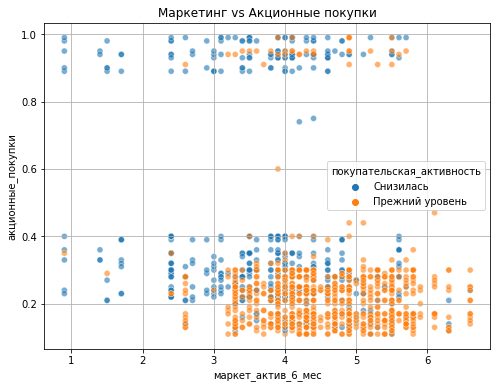

In [67]:
# Маркетинг vs Акционные покупки
plt.figure(figsize=(8, 6))
sns.scatterplot(data=final_df, x='маркет_актив_6_мес', y='акционные_покупки', hue='покупательская_активность', alpha=0.6)
plt.title('Маркетинг vs Акционные покупки')
plt.grid(True)
plt.show()

Из диаграммы рассеяния Маркет_актив_6_мес vs Акционные_покупки видно, что клиенты с низкой долей акций и нормальной маркет-активностью чаще сохраняют активность. Покупатели с высокой долей акционных покупок — более рискованны по снижению интереса.
Выглядит будто зависимость от акций не гарантирует долгосрочную лояльность.<br>

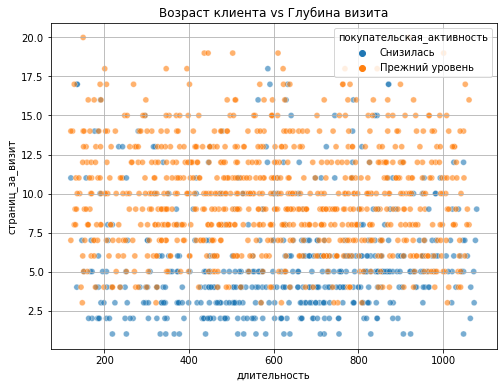

In [68]:
# Длительность vs Страниц_за_визит
plt.figure(figsize=(8, 6))
sns.scatterplot(data=final_df, x='длительность', y='страниц_за_визит', hue='покупательская_активность', alpha=0.6)
plt.title('Возраст клиента vs Глубина визита')
plt.grid(True)
plt.show()

Из диаграммы рассеяния Возраст клиента vs Глубина визита (где возрастом мы считаем количество дней после регистрации аккаунта) видно, что хоть и нет прямой зависимости, но более старые клиенты с глубокой вовлечённостью реже теряют активность. В то время как молодые клиенты имеют низкую вовлечённость, возможно им стоит давать больше рекомендаций при первых визитах, чтобы увеличить  интерес<br>

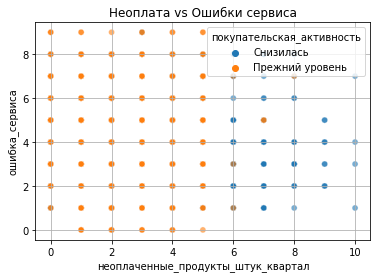

In [69]:
# Неоплата vs Ошибки сервиса
sns.scatterplot(data=final_df, x='неоплаченные_продукты_штук_квартал', y='ошибка_сервиса', hue='покупательская_активность', alpha=0.6)
plt.title('Неоплата vs Ошибки сервиса')
plt.grid(True)
plt.show()

Из диаграммы рассеяния Неоплата vs Ошибки сервиса видно, что клиенты с шестью и более неоплаченными товарами попадают в группу покупательская активность снизилась, стоит взять признак Неоплаченные_продукты_штук_квартал в модель. А ошибка сервиса, вероятно, слабый признак.<br>
Из диаграммы рассеяния Средний_просмотр_категорий_за_визит vs Страниц_за_визит видно что чем больше клиент смотрит категорий, тем больше он просматривает страниц (что логично)

Рассмотрим как изменялась выручка за пероид, охваченный данными

<Figure size 720x432 with 0 Axes>

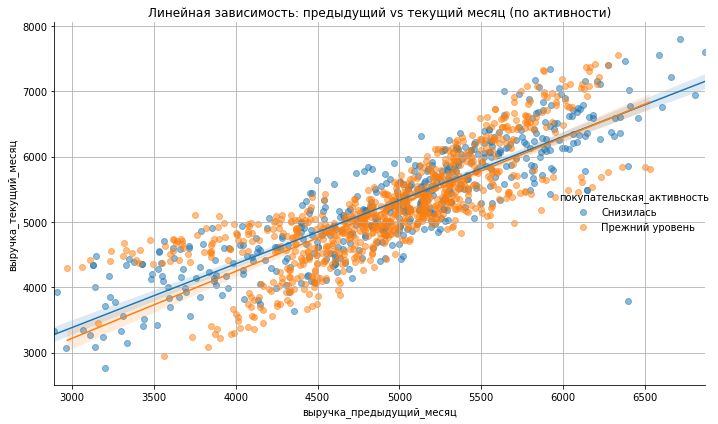

In [70]:
# Построим диаграмму рассеяния с линией регрессии (линейная модель)
plt.figure(figsize=(10, 6))
sns.lmplot(
    data=final_df,
    x='выручка_предыдущий_месяц',
    y='выручка_текущий_месяц',
    hue='покупательская_активность',
    height=6,
    aspect=1.3,
    scatter_kws={'alpha':0.5},
    line_kws={'linewidth':1.5}
)
plt.title('Линейная зависимость: предыдущий vs текущий месяц (по активности)')
plt.grid(True)
plt.tight_layout()
plt.show()


Линейная зависимость между выручкой в текущем и предыдущем месяце очень сильная, выглядмт будто клиенты, совершившие покупки в прошлом месяце, не совершают их в текущем. Посмотрим, наблюдалось ли такое поведение месяц назад

<Figure size 720x432 with 0 Axes>

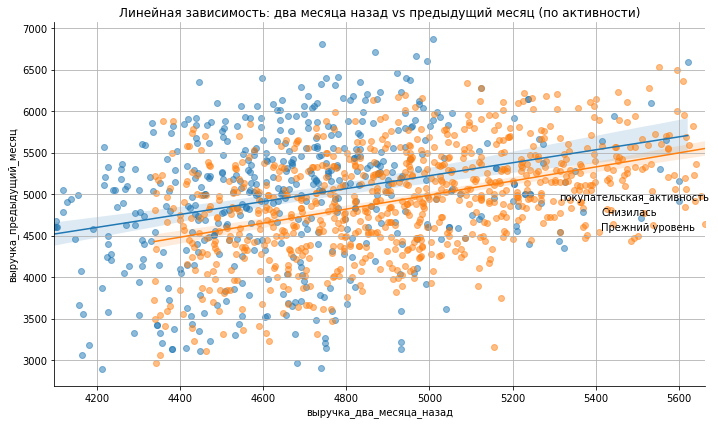

In [71]:
# Построим диаграмму рассеяния с линией регрессии (линейная модель)
plt.figure(figsize=(10, 6))
sns.lmplot(
    data=final_df,
    x='выручка_два_месяца_назад',
    y='выручка_предыдущий_месяц',
    hue='покупательская_активность',
    height=6,
    aspect=1.3,
    scatter_kws={'alpha':0.5},
    line_kws={'linewidth':1.5}
)
plt.title('Линейная зависимость: два месяца назад vs предыдущий месяц (по активности)')
plt.grid(True)
plt.tight_layout()
plt.show()

Гипотезу отвергаем, два месяца назад клиенты показывали стабильное поведение. Посмотрим в какой группе клиентов разница между выручкой стала резче, для этого добавим новый столбец: сумма выручки за два предыдущих месяца

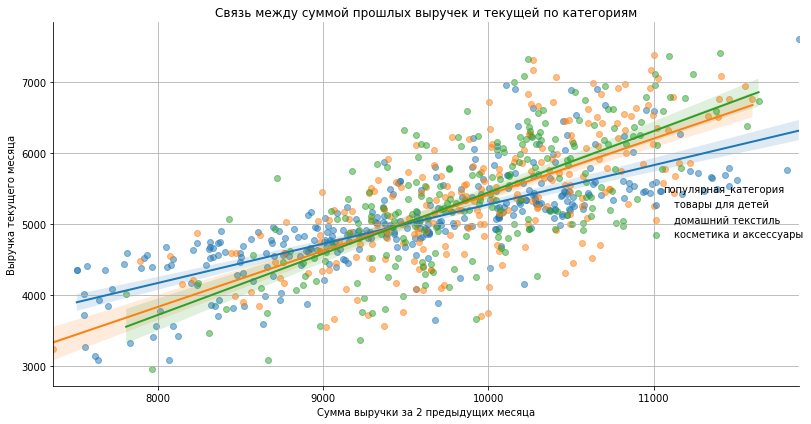

In [72]:
# Создаём признак: сумма выручки за два предыдущих месяца
final_df['выручка_двух_предыдущих'] = (
    final_df['выручка_предыдущий_месяц'] + final_df['выручка_два_месяца_назад']
)
# Фильтруем только категории, где наблюдается сильная визуальная зависимость
top_categories = final_df['популярная_категория'].value_counts().index[:3]  # возьмем топ-3

filtered_df = final_df[final_df['популярная_категория'].isin(top_categories)]

# Строим графики
g = sns.lmplot(
    data=filtered_df,
    x='выручка_двух_предыдущих',
    y='выручка_текущий_месяц',
    hue='популярная_категория',
    aspect=1.5,
    height=6,
    scatter_kws={'alpha': 0.5},
    line_kws={'linewidth': 2}
)

g.set_axis_labels("Сумма выручки за 2 предыдущих месяца", "Выручка текущего месяца")
plt.title("Связь между суммой прошлых выручек и текущей по категориям")
plt.grid(True)
plt.tight_layout()
plt.show()

Суммарная выручка за два предыдущих месяца практически точно показывает, какая выручка будет в текущем месяце, что говорит о том что клиенты стабильно тратят примерно столько же, что и раньше
Возможно клиенты совершают регулярные покупки (расходующиеся детские товары, бытовую химию и тд)

Посмотрим как изменялась покупательская активность у клиентов по их айди в контексте таргета

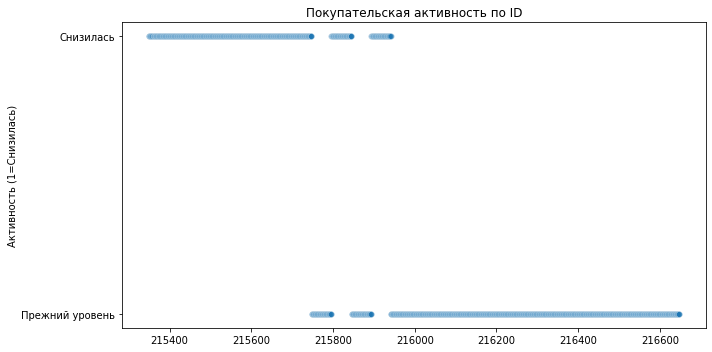

In [73]:
# Создаём график для таргета
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), sharex=True)

# Сортируем по ID для наглядности
final_df_sorted = final_df.sort_values(by="id")

# Покупательская активность по id
sns.scatterplot(
    data=final_df_sorted,
    x="id",
    y="покупательская_активность",
    alpha=0.5,
    ax=axes
)
axes.set_title("Покупательская активность по ID")
axes.set_ylabel("Активность (1=Снизилась)")
axes.set_xlabel("")

plt.tight_layout()
plt.show()

Наблюдается интересный эффект, активность снизилась у клиентов с близким айди. Так как айди присваивается ситсемой при регистрации автоматически, и это уникальный последовательно возрастающий номер, можно сделать предположение о том, что активность у клиентов снижается группами
Возможно это связано с каналом привлечения клиентов
Или с какой-то другой спеицификой конкретных групп пользователей (они все пришли примерно в одно время)

Посмотрим дельту между выручкой за текущий и предудщий месяц

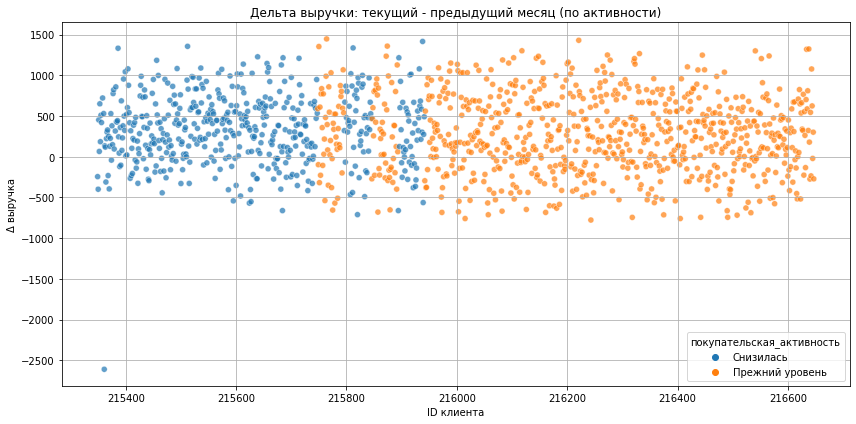

In [74]:
# Рассчитаем дельту между текущей и предыдущей выручкой
final_df['дельта_выручка'] = final_df['выручка_текущий_месяц'] - final_df['выручка_предыдущий_месяц']

# Строим scatter plot по id и дельте выручки, с цветом по активности
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=final_df,
    x='id',
    y='дельта_выручка',
    hue='покупательская_активность',
    alpha=0.7
)
plt.title('Дельта выручки: текущий - предыдущий месяц (по активности)')
plt.xlabel('ID клиента')
plt.ylabel('Δ выручка')
plt.grid(True)
plt.tight_layout()
plt.show()

Видно что снижение выручки дейсвительно связано с уменьшением активности

Проведём расчёт коэффициента Пирсона между количественными признаками

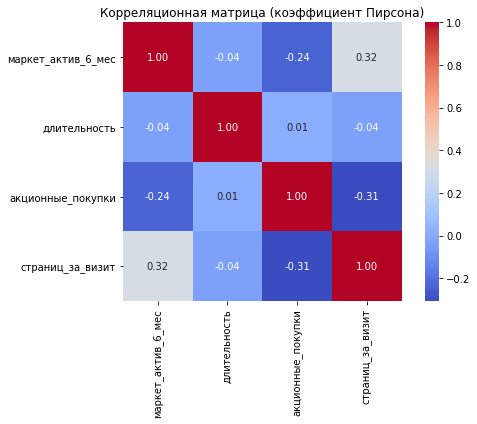

In [75]:
# Вычисляем корреляционную матрицу
correlation_matrix = final_df[quantitative_features].corr(method='pearson')

# Визуализация
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title('Корреляционная матрица (коэффициент Пирсона)')
plt.tight_layout()
plt.show()

Наблюдается умеренная положительная корреляция между признаками Активный маркетинг и Количество страниц за визит (коэффициент Пирсона 0.31)
Это может свидетельствовать о том, что активное маркетинговое воздействие повышает вовлечённость клиентов, выражающуюся в просмотре большего количества страниц на сайте<br>
В то же время существует обратная связь между Активным маркетингом и Долей акционных покупок (-0.24)
Это может указывать на то, что чрезмерное маркетинговое воздействие смещает внимание клиента от акционных предложений к другим типам товаров или усиливает осознанность в выборе<br>
Акционные покупки  показывают относительно сильную отрицательную корреляцию с количеством страниц за визит (-0.30)
Возможно клиенты, ориентированные на акции, тратят меньше времени на изучение сайта, переходя сразу к целевым товарам, что снижает вовлечённость<br>

В ходе проведения корреляционного анализа данных были построены диаграммы рассеяния и матрица корреляции. Мультиколлинеарность не выявлена — все коэффициенты между признаками находятся в допустимом диапазоне, и отсутствуют пары с избыточной корреляцией.<br>
<br>
<b>В результате корреляционного анализа данных были выявлены следующие особенности:</b><br>
Из диаграммы рассеяния Маркет_актив_6_мес vs Акционные_покупки видно, что клиенты с низкой долей акций и нормальной маркет-активностью чаще сохраняют активность. Покупатели с высокой долей акционных покупок — более рискованны по снижению интереса.
Выглядит будто зависимость от акций не гарантирует долгосрочную лояльность.<br>
Из диаграммы рассеяния Возраст клиента vs Глубина визита (где возрастом мы считаем количество дней после регистрации аккаунта) видно, что хоть и нет прямой зависимости, но более старые клиенты с глубокой вовлечённостью реже теряют активность. В то время как молодые клиенты имеют низкую вовлечённость, возможно им стоит давать больше рекомендаций при первых визитах, чтобы увеличить  интерес<br>
Из диаграммы рассеяния Неоплата vs Ошибки сервиса видно, что клиенты с шестью и более неоплаченными товарами попадают в группу покупательская активность снизилась, стоит взять признак Неоплаченные_продукты_штук_квартал в модель. А ошибка сервиса, вероятно, слабый признак.<br>
Из диаграммы рассеяния Средний_просмотр_категорий_за_визит vs Страниц_за_визит видно что чем больше клиент смотрит категорий, тем больше он просматривает страниц (что логично)<br>
Линейная зависимость между выручкой в текущем и предыдущем месяце очень сильная<br>
Суммарная выручка за два предыдущих месяца практически точно показывает, какая выручка будет в текущем месяце, что говорит о том что клиенты стабильно тратят примерно столько же, что и раньше
<br>
Возможно клиенты совершают регулярные покупки (расходующиеся детские товары, бытовую химию и тд)
<br>
Наблюдается интересный эффект, активность снизилась у клиентов с близким айди. Так как айди присваивается ситсемой при регистрации автоматически, и это уникальный последовательно возрастающий номер, можно сделать предположение о том, что активность у клиентов снижается группами
Возможно это связано с каналом привлечения клиентов<br>
Или с какой-то другой спеицификой конкретных групп пользователей (они все пришли примерно в одно время)<br>
Наблюдается умеренная положительная корреляция между признаками Активный маркетинг и Количество страниц за визит (коэффициент Пирсона 0.31)
<br>
Это может свидетельствовать о том, что активное маркетинговое воздействие повышает вовлечённость клиентов, выражающуюся в просмотре большего количества страниц на сайте<br>
В то же время существует обратная связь между Активным маркетингом и Долей акционных покупок (-0.24)
Это может указывать на то, что чрезмерное маркетинговое воздействие смещает внимание клиента от акционных предложений к другим типам товаров или усиливает осознанность в выборе<br>
Акционные покупки  показывают относительно сильную отрицательную корреляцию с количеством страниц за визит (-0.30)
Возможно клиенты, ориентированные на акции, тратят меньше времени на изучение сайта, переходя сразу к целевым товарам, что снижает вовлечённость<br>

<h2>Использование пайплайнов</h2>

В ходе работы будут обучены четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC()<br>
Обработка качественных и количественных признаков, при этом, будет проходить в раздельных пайплайнах<br>
Для кодирования категориальных признаков используем минимум два кодировщика, для масштабирования количественных — минимум два скейлера.<br>
В качестве метрики будем использовать roc_auc так как перед нами задача бинарной классификации, узнать снизилась или осталась на прежнем уровне покупательская активность. То есть интерес представляют и точность, и полнота. Ошибки первого и второго рода могут нести разный вес.<br>
С помощью этой метрики мы сможем корректно оценить способность моделей разделять классы

Преобразуем целевой признак в бинарный, чтобы в дальнейшем он был корректно интерпретирован shap

In [76]:
# Преобразуем целевой признак в бинарный (1 = Снизилась, 0 = осталась прежней)
final_df['покупательская_активность'] = (
    final_df['покупательская_активность'] == 'Снизилась'
).astype(int)
print(final_df['покупательская_активность'].value_counts())

0    802
1    494
Name: покупательская_активность, dtype: int64


Установим константы

In [77]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

Разобъём данные на выборки

In [78]:
X_train, X_test, y_train, y_test = train_test_split(
    final_df.drop(['покупательская_активность'], axis=1),
    final_df['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = final_df['покупательская_активность'])

X_train.shape, X_test.shape

((972, 19), (324, 19))

Разделим признаки на списки для соответсвующих кодировщиков

In [79]:
# создаём списки с названиями признаков
ohe_columns = ['популярная_категория']
ord_columns = ['тип_сервиса', 'разрешить_сообщать']
num_columns = ['маркет_актив_тек_мес', 'маркет_актив_6_мес', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'длительность', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_два_месяца_назад', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц',
'количество_минут_предыдущий_месяц', 'количество_минут_текущий_месяц']

Создадим пайплайны для кодирования признаков

In [80]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'], 
                    ['да', 'нет']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

Теперь создадим общий пайплайн для обработки данных

In [81]:
# создаём общие пайплайны для подготовки данных
# OneHot + MinMaxScaler
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ]
)

Подготовим итоговый пайплайн с моделью

In [82]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])


Объявим словари гипрепараметров для каждой из моделей

In [83]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),  
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели SVC()
    {
        'models': [SVC(
            random_state=RANDOM_STATE, 
            probability=True
        )],
        'models__C': np.logspace(-2, 1, 5),  
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

Запустим автоматический подбор лучших гиперпараметров для моделей с помощью RandomizedSearchCV

In [84]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Лучшая модель по результатам кросс-валидации (ROC AUC):', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(cat

По результатам подбора гиперпараметров лучшей моделью оказалась SVC с включённой вероятностной оценкой и C=1.78. Это значение говорит о сбалансированном уровне регуляризации: модель стремится точно разделить классы, но при этом остаётся устойчива к переобучению.<br>

Теперь запустим тестирование выбранной SVC модели и посмотрим значение ROC AUC на тестовой выборке

In [85]:
# Предсказание вероятностей
y_pred_proba = randomized_search.best_estimator_.predict_proba(X_test)[:, 1]

# Предсказание классов
y_pred = randomized_search.best_estimator_.predict(X_test)

# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Финальный ROC AUC на тестовой выборке: ", roc_auc)


Финальный ROC AUC на тестовой выборке:  0.9119038951583547


Значение метрики ROC AUC очень высокое, 0.92, что говорит о хорошей способности модели корректно различать классы

На всякий случай проверим прогноз модели на адекватность

In [86]:
dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
y_dummy_pred = dummy.predict_proba(X_test)[:, 1]

roc_auc_dummy = roc_auc_score(y_test, y_dummy_pred)
print("ROC AUC для DummyClassifier: ", roc_auc_dummy)

ROC AUC для DummyClassifier:  0.5


Похоже на случайное угадывание, то есть модель не подгоняет прогноз на дисбалансе классов

Мы использовали пайплайны чтобы предварительно подготовить данные (кодирование категориальных признаков и масштабирование количественных) и затем провести обучение четёрых разных моделей с подбором гиперпараметров. Для оценки качества модели была выбрана метрика ROC AUC так как решается задача бинарной классификации, в которой ошибки первого и второго рода имеют разный вес и в то же время нам важно, на сколько точно модель присваевает соответствующий класс.<br>
По результатам подбора гиперпараметров лучшей моделью оказалась SVC с включённой вероятностной оценкой и C=1.78. Это значение говорит о сбалансированном уровне регуляризации: модель стремится точно разделить классы, но при этом остаётся устойчива к переобучению.<br>
Значение метрики ROC AUC очень высокое, 0.92, что говорит о хорошей способности модели корректно различать классы

<h2>Анализ важности признаков</h2>

На этапе анализа важности признаков мы проведём интерпретацию выбранной модели SVC чтобы лучше понять её характер. Для этого нам необходимо разобраться с тем, какие признаки модель оценила как наиболее важные.<br>
Однозначную оценку вклада признака в каждый прогноз показывают значения Шепли, их оценивают методом SHAP (SHapley Additive exPlanations). Он вычисляет, как отдельный признак помог присвоить модели итоговое значение целевого.<br>

Сначала достанем нашу модель и обработанные данные из пайплайна

In [87]:
best_model = randomized_search.best_estimator_
preprocessor = best_model.named_steps['preprocessor']
model_svc = best_model.named_steps['models'] 
X_test_transformed = preprocessor.transform(X_test)
X_test_transformed

array([[ 0.        ,  0.        ,  0.        , ..., -2.32046299,
         0.62405133,  0.89466847],
       [ 0.        ,  0.        ,  0.        , ..., -1.27157192,
        -0.64760044, -1.02448795],
       [ 1.        ,  0.        ,  0.        , ...,  1.30466638,
         1.64137274, -0.54469884],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -2.25537582,
        -0.13893973,  0.17498481],
       [ 0.        ,  1.        ,  0.        , ...,  1.45554487,
         0.11539062, -0.78459339],
       [ 0.        ,  0.        ,  1.        , ...,  0.57561867,
        -1.15626114, -0.54469884]])

Далее инициализируем shap, для SVC модели, согласно документации, подходит метод SamplingExplainer  (он универсален)

In [88]:
# получаем имена признаков после трансформации
ohe_feature_names = preprocessor.named_transformers_['ohe'].named_steps['ohe'].get_feature_names_out(ohe_columns)

# объединяем всё
feature_names = list(chain(
    ohe_feature_names,
    ord_columns,
    num_columns
))

X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# объяснение
explainer = shap.Explainer(model_svc.predict_proba, X_test_df.values, algorithm='permutation')
shap_values = explainer(X_test_df.values)

print("SHAP:", shap_values.shape)
print("X_test:", X_test_df.shape)

PermutationExplainer explainer: 325it [04:11,  1.26it/s]                         

SHAP: (324, 21, 2)
X_test: (324, 21)


Построим графики для класса 1, то есть для тех признаков, которые внесли вклад в то что активность снизилась

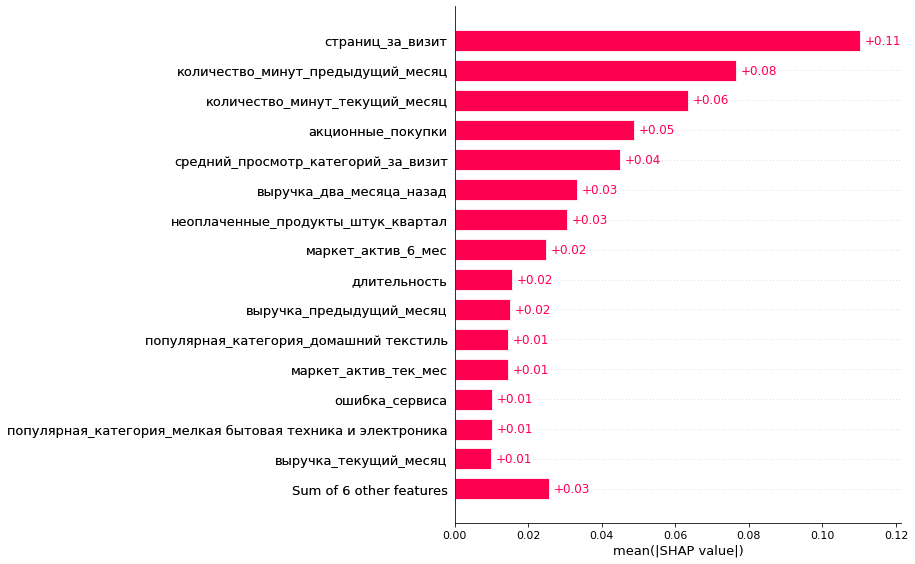

In [89]:
shap_values_class_1 = shap_values.values[:, :, 1]
shap_exp = shap.Explanation(
    values=shap_values_class_1,
    base_values=shap_values.base_values[:, 1],  # базовые значения для класса 1
    data=X_test_df.values,
    feature_names=list(X_test_df.columns)
)
# bar chart — вклад признаков
shap.plots.bar(shap_exp, max_display=16)

Как видим наибольший вклад оказывает признак количество страниц за визит. Чем больше страниц клиент смотрит за визит, тем меньше вероятность снижения активности. Это явный признак вовлечённости.<br>
Затем идут количество минут в текущем и предыдущем месяце — то есть по количеству времени, проведённом на сайте, можно сделать вывод об активности пользователя<br>
Далее акционные пакупки, клиенты, покупающие по акциям, менее склонны снижать активность. Видимо, акции удерживают интерес.<br>
Средний просмотр категорий за визит также активно влияет и указывает на глубину интереса, чем больше категорий за визит, тем выше вовлечённость

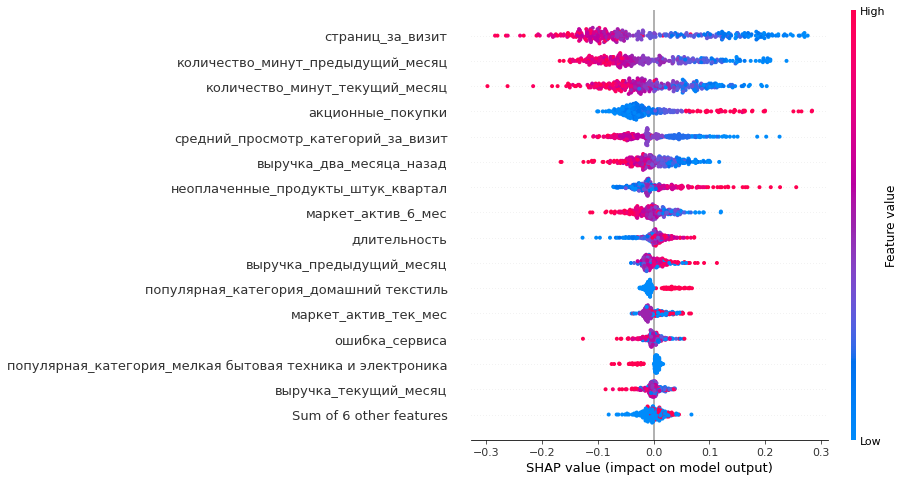

In [90]:
# beeswarm
shap.plots.beeswarm(shap_exp, max_display=16)

Наиболее важные признаки можно разбить на три категории, в зависимости от их влияния на вероятность снижения активности:<br>
К первой категории относятся признаки, которые оказывают сильное влияние в обе стороны, в зависимости от значения, к ним относятся:<br>
- страниц за визит и количество минут:  
  клиенты, просматривающие больше страниц и проводящие больше времени на сайте, как правило, сохраняют стабильную активность. Снижение этих показателей, наоборот, увеличивает вероятность падения интереса к платформе.<br>
  
Далее признаки, при высоком значении которых вероятность снижения активности повышается:<br>

- Акционные_покупки — чем выше доля покупок по акциям, тем выше вероятность снижения активности. 
Это может указывать на то, что такие клиенты менее лояльны и ориентированы на выгоду, а значит, при отсутствии акций они снижают активность.<br>

- неоплаченные продукты штук квартал:  
 чем больше таких товаров, тем выше вероятность, что клиент снизит активность — возможно, он не завершает покупки, теряет интерес или сталкивается с барьерами на этапе оформления<br>

Признаки, при высоких значениях которых вероятность снижения активности уменьшается:

- средний просмотр категорий за визит:  
  повышенная глубина просмотра категорий также говорит о высокой вовлечённости. При этом резкое снижение этого признака заметно увеличивает вероятность потери интереса.<br>


Таким образом, основной риск снижения активности связан не с типом сервиса или исторической выручкой, а с текущей вовлечённостью: количеством просмотренных страниц, временем на сайте и интересом к каталогу.<br>
В то время как ошибки сервиса, тип сервиса слабо влияют на активность клиентов<br>
В модель необходимо включить следующие ключевые признаки:Страниц_за_визит, Количество_минут, Акционные_покупки<br>
Можно исключить Тип_сервиса, Маркет_актив_тек_мес как слабые<br>
Для бизнеса важным будет учесть, что снижение глубины визтов является одним из наиболее сильных индиакторов. Возможно, стоить включить триггеры удержания (направлять рассылки после нескольких дней неактивности)<br>
Также стоит отметить что клиненты, которые активно просматривают категории, реже падают. Есть вероятность необходимости добавления релевантных подборок или организация механизма ротации товаров на сайте<br>
Неоплаченные товары — это потенциальные сделки, возможно стоит напоминать об их наличии<br>
Акции повышают шанс остаться, но не спасают от снижения активности в долгосрочной перспективе, так что стоит рассматривать эту стратегию как не единственную, а в комплексе с остальными

<h2>Сегментация покупателей</h2>

Выполним сегментацию покупателей. Для этого будем использовать результаты моделирования и данные о прибыльности покупателей. На тестовой выборке выведим диаграмму рассеяния по прибыли и вероятности понижения активности выданной моделью SVC.<br>
По этому графику отбирём часть клиентов, у кого прибыль значительная, а вероятность высокая.<br> 
Рассмотрим свойства выбранного сегмента и то, как их изменение влияет на вероятность понижения активности<br>

Для начала возьмём из пайплайна вероятность снижения активности, предсказанную моделью

In [91]:
# Предсказываем вероятность снижения активности
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
print(X_test.shape) 
print(y_pred_proba[:5])

(324, 19)
[0.02919273 0.96225708 0.21495916 0.94625152 0.18512578]


Присоединим прибыль и предсказание к тестовым данным

In [92]:
# Добавим предсказание в X_test
X_test_copy = X_test.copy()
X_test_copy['y_pred_proba'] = y_pred_proba

# Присоединяем прибыль
X_test_with_money = X_test_copy.merge(data_money[['id', 'прибыль']], on='id', how='left')
X_test_with_money.head(5)

,id,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,...,страниц_за_визит,выручка_два_месяца_назад,выручка_предыдущий_месяц,выручка_текущий_месяц,количество_минут_предыдущий_месяц,количество_минут_текущий_месяц,выручка_двух_предыдущих,дельта_выручка,y_pred_proba,прибыль
0,216161,стандарт,да,4.1,4,606,0.15,техника для красоты и здоровья,6,1,...,12,4912.0,3973.0,3289.2,16,17,8885.0,-683.8,0.029193,4.69
1,215654,премиум,нет,1.4,4,684,0.94,товары для детей,3,6,...,6,4656.0,3548.0,4170.7,11,9,8204.0,622.7,0.962257,2.75
2,216307,премиум,да,3.3,4,488,0.13,домашний текстиль,4,2,...,10,4565.0,5444.0,6335.8,20,11,10009.0,891.8,0.214959,3.16
3,215501,премиум,да,3.5,3,1057,0.35,домашний текстиль,4,3,...,6,4993.0,6604.0,6758.7,9,9,11597.0,154.7,0.946252,3.74
4,215934,стандарт,нет,5.5,4,147,0.99,мелкая бытовая техника и электроника,1,2,...,7,4451.0,5090.0,5773.8,15,18,9541.0,683.8,0.185126,4.40


Посторим диаграмму рассеяния

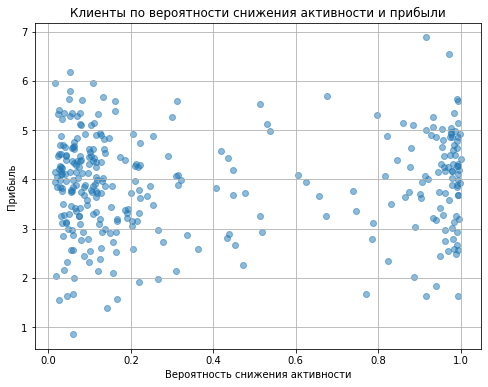

In [93]:
plt.figure(figsize=(8, 6))
plt.scatter(
    X_test_with_money['y_pred_proba'],
    X_test_with_money['прибыль'],
    alpha=0.5
)
plt.xlabel('Вероятность снижения активности')
plt.ylabel('Прибыль')
plt.title('Клиенты по вероятности снижения активности и прибыли')
plt.grid(True)
plt.show()

По графику мы видим, что клиентов можно условно разделить на четыре группы:<br>
с высокой прибылью и низкой вероятностью снижения активности<br>
с низкой прибылью и низкой вероятностью снижение активности<br>
с высокой прибылью и выскокой вероятностью снижения активности<br>
с низкой прибылью и выскокой вероятностью снижение активности<br>

Наиболее интересным представляется сегмент справа, с высокой прибылью и высокой вероятностью снижения активности. Граница для отделения этого сегмента проходит примерно по 0.8<br> Этот сегмент интересен тем, что его удержание поможет сохранить прибыль для бизнеса<br>
Рассмотрим сегмент клиентов с высокой прибылью и высокой вероятностью снижения активности более подробно

Выделим целевой сегмент в отдельный датафрейм для анализа

In [94]:
risk_threshold = 0.8
profit_threshold = X_test_with_money['прибыль'].median()

segment = X_test_with_money[
    (X_test_with_money['y_pred_proba'] > risk_threshold) &
    (X_test_with_money['прибыль'] > profit_threshold)
]
segment.head(10)

,id,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,...,страниц_за_визит,выручка_два_месяца_назад,выручка_предыдущий_месяц,выручка_текущий_месяц,количество_минут_предыдущий_месяц,количество_минут_текущий_месяц,выручка_двух_предыдущих,дельта_выручка,y_pred_proba,прибыль
12,215375,премиум,да,3.0,4,558,0.89,товары для детей,3,3,...,4,4715.0,5253.5,5633.1,8,9,9968.5,379.6,0.994698,4.18
18,215452,стандарт,да,3.8,4,756,0.90,товары для детей,2,3,...,4,4963.0,4045.0,4206.2,11,10,9008.0,161.2,0.974017,4.50
21,215484,премиум,нет,2.9,5,448,0.23,товары для детей,4,2,...,3,4267.0,5059.0,5018.7,5,7,9326.0,-40.3,0.991847,5.64
38,215496,премиум,да,4.0,4,684,0.40,техника для красоты и здоровья,1,6,...,4,4896.0,5020.0,5237.1,11,11,9916.0,217.1,0.990243,4.64
47,215666,стандарт,да,3.5,5,703,0.22,товары для детей,2,2,...,2,4138.0,4945.0,5150.4,6,10,9083.0,205.4,0.980120,4.02
48,215737,стандарт,да,0.9,4,225,0.36,косметика и аксессуары,2,4,...,3,4679.0,5126.0,5291.1,9,10,9805.0,165.1,0.956380,4.80
55,215604,стандарт,нет,3.1,5,458,0.99,косметика и аксессуары,1,5,...,4,4308.0,4449.0,4459.4,8,10,8757.0,10.4,0.977994,4.86
60,215628,стандарт,да,4.0,4,618,0.93,товары для детей,3,5,...,2,4566.0,3783.0,3848.0,9,10,8349.0,65.0,0.993795,4.11
62,215565,стандарт,нет,2.4,4,522,0.99,кухонная посуда,2,5,...,4,4492.0,4657.0,5104.2,11,12,9149.0,447.2,0.981058,4.32
63,215402,премиум,да,3.0,5,954,0.93,товары для детей,3,2,...,6,4702.0,4918.0,4940.1,5,5,9620.0,22.1,0.991162,4.28


Посмотрим, как признаки распределяются внтутри сегмента

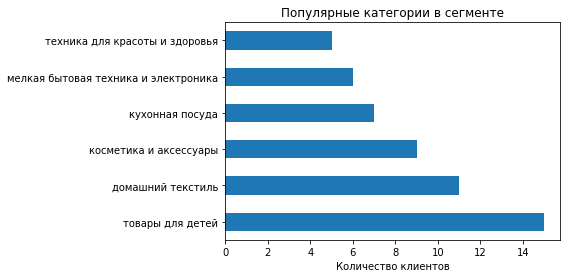

In [95]:
# Распределение по популярной категории
segment['популярная_категория'].value_counts().plot(kind='barh', title='Популярные категории в сегменте')
plt.xlabel('Количество клиентов')
plt.show()

Среди популярной категории лидируют товары для детей, посмотрим все категориальные и количественные признаки

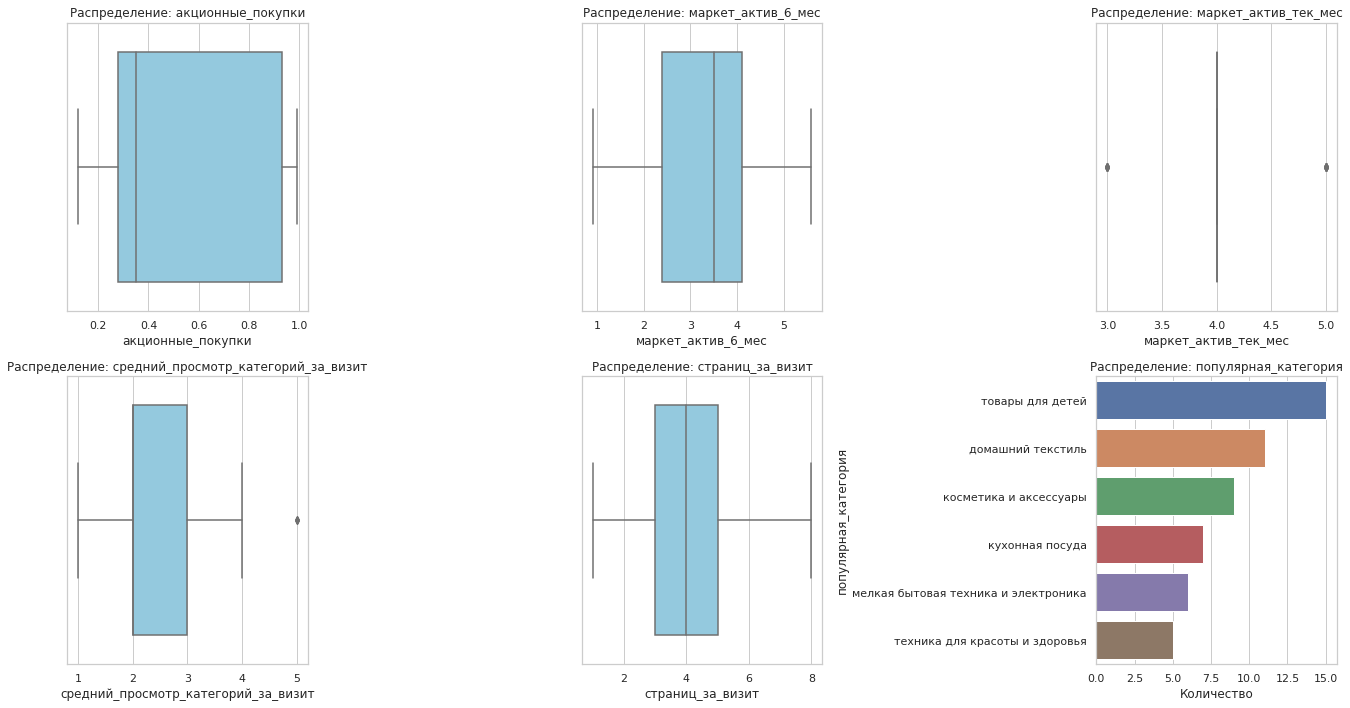

In [96]:
# Настроим стиль графиков
sns.set(style="whitegrid")

# Отображаемые признаки
features_to_plot = [
    'акционные_покупки',
    'маркет_актив_6_мес',
    'маркет_актив_тек_мес',
    'средний_просмотр_категорий_за_визит',
    'страниц_за_визит',
    'популярная_категория'
]

# Построим графики
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    if segment[feature].dtype == 'object':
        # Гистограмма для категориального признака
        sns.countplot(data=segment, y=feature, order=segment[feature].value_counts().index, ax=axes[i])
        axes[i].set_xlabel('Количество')
        axes[i].set_title(f'Распределение: {feature}')
    else:
        # Ящик с ушами для числового признака
        sns.boxplot(data=segment, x=feature, ax=axes[i], color='skyblue')
        axes[i].set_title(f'Распределение: {feature}')

plt.tight_layout()
plt.show()

По акционным покупкам видно, что сегмент умеренно ориентирован на акции (медиана 0.3). Большинство клиентов просматривают 2-3 категории за визит и порядка 4х страниц. Лидирующая категория товары для детей.<br> 
Проверим, приведёт ли увелечение значения среднего просмотра категорий зв визит, например, через блоки с рекомендациями или поп-ап с кросс-категориям), к снижению вероятности уменьшения активности

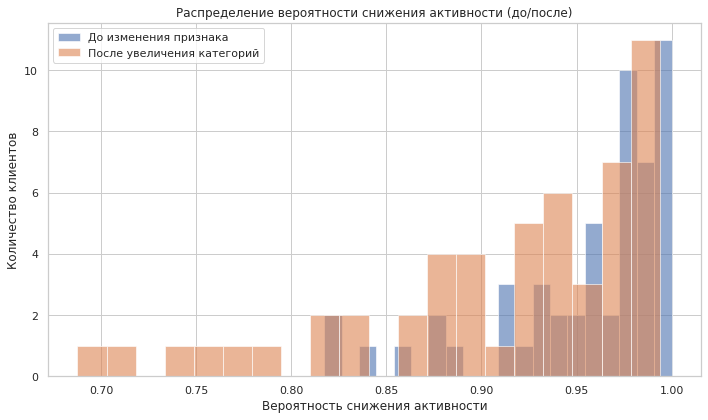

In [97]:
# Создаём копию сегмента, чтобы не изменять оригинальные данные
segment_modified = segment.copy()

# Увеличиваем значение среднего просмотра категорий за визит (например, с текущего значения до 5)
segment_modified['средний_просмотр_категорий_за_визит'] = 5

# Пропускаем модифицированные данные через препроцессор
segment_transformed = preprocessor.transform(segment_modified)

# Предсказываем вероятность снижения активности на модифицированных данных
segment_pred_modified = model_svc.predict_proba(segment_transformed)[:, 1]

# Предсказываем вероятность на исходных данных (для сравнения)
segment_original_transformed = preprocessor.transform(segment)
segment_pred_original = model_svc.predict_proba(segment_original_transformed)[:, 1]

# Строим сравнение
plt.figure(figsize=(10, 6))
plt.hist(segment_pred_original, bins=20, alpha=0.6, label='До изменения признака')
plt.hist(segment_pred_modified, bins=20, alpha=0.6, label='После увеличения категорий')
plt.title('Распределение вероятности снижения активности (до/после)')
plt.xlabel('Вероятность снижения активности')
plt.ylabel('Количество клиентов')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

На графике синим цветом отражены данные до изменения признака, и график смещён вправо. То есть выроятность 82% и выше что пользователи из рассматриваемого сегмента сокартят активность.<br> 
После увеличения вовлечённости (количество просмотренных категорий до пяти) график сдвинулся влево и вероятность снижения активности для некоторых пользовотелей уменьшилась до 65% что можно рассматривать как позитивную тендецию<br> 
Таким образом, повышение количества категорий, которые пользователь просматривает за визит (например, за счёт рекомендаций, смежных товаров и т.п.), может быть эффективной стратегией удержания.<br> 
Предложения по работе с целевым сегментом (прибыльными клиентами со снижением активности):<br> 
Повышение вовлечённости через просмотр категорий:<br>
    Добавить блоки рекомендованных товаров в карточки и категории — особенно из смежных и популярных сегментов<br>
    Использовать персонализированную ленту: выводить категории, в которых клиент ранее проявлял интерес<br>
    Применить карусели «с этим покупают», «вы смотрели» и тд, чтобы клиент не ограничивался одной категорией<br>


Для проведения дополнительного исследования по сегментации покупателей был выбран сегмент клиентов, которые приносят большую прибыль компании, но при этом вероятность снижения их активности по прогнозу модели находится от 82 до 100%.<br> 
Такие клиенты кажутся наиболее интересными для исследования, так как их потеря может привести к существенному сокращению прибыли.<br> 
Для проведения исследования была составлена гипотеза, о том что вероятность снижения активонсти снизится при повышении вовлечённости за счёт роста просматриваемых категорий. На этот признак можно повлиять, например, добавлением блоков с персональной рекомендацией категорий<br> 
Дааная гипотеза была протестирована, она подтвердилась, на основе этого были сформулированы предложения по повышению вовлечённости через просмотр категорий:<br> 
    Добавить блоки рекомендованных товаров в карточки и категории — особенно из смежных и популярных сегментов<br>
    Использовать персонализированную ленту: выводить категории, в которых клиент ранее проявлял интерес<br>
    Применить карусели «с этим покупают», «вы смотрели» и тд, чтобы клиент не ограничивался одной категорией<br>

<h2>Общий вывод</h2>

<h2>Общий вывод</h2>
В рамках проекта для Интернет-магазина «В один клик» мы построили и обучили четыре модели для редсказания снижения покупательской активности посредством пайплайнов. Для анализа были предоставлены данные в четырёх файлах:
<b>Описание данных</b>
<br><br>
market_file.csv
<br>
Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
    id — номер покупателя в корпоративной базе данных.<br>
    Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».<br>
    Тип сервиса — уровень сервиса, например «премиум» и «стандарт».<br>
    Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.<br>
    Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
    Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.<br>
    Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.<br>
    Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.<br>
    Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.<br>
    Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.<br>
    Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.<br>
    Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.<br>
    Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.
<br>
<br>
	market_money.csv<br>
Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.<br>
    id — номер покупателя в корпоративной базе данных.<br>
    Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.<br>
    Выручка — сумма выручки за период.<br>
<br>
market_time.csv<br>
Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.<br>
    id — номер покупателя в корпоративной базе данных.<br>
    Период — название периода, во время которого зафиксировано общее время.<br>
    минут — значение времени, проведённого на сайте, в минутах.<br>
<br>
money.csv<br>
Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.<br>
    id — номер покупателя в корпоративной базе данных.<br>
    Прибыль — значение прибыли.<br>
<br>
<b>План работ</b><br>
1. Загрузка и изучение данных (парсинг, нейминг столбцов)
2. Предобработка данных (явные и неявные дубликаты, пропуски)
3. Исследовательский анализ данных (описание данных, статистических анализ всех признаков с гистограммами для количественных и столбчатами/круговыми диаграммами для качественных признаков, выбросы, рекомендации по улучшению данных, их применение)
4. Объединение таблиц (market_file.csv, market_money.csv, market_time.csv)
5. Корреляционный анализ признаков в датасете market_main.csv (диаграмма рассеяния, матрица корреляции)
6. Использование пайплайнов (для моделей KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC())
7. Анализ важности признаков (с помощью метода SHAP)
8. Сегментация покупателей (графическое и аналитическое исследование группы покупателей)
9. Итоговые выводы 

Из технических деталей — во время работы пришлось обновить и установить некоторые отсутствующие библиотеки. Для удобства загрузки данных из четрых файлов мы реализовали собственную функцию. В данных использовались разные разделители. Названия колонок отличасись от файла к файлу и мы привели их все к единому виду<br>
В результате <b>предобработки данных</b> названия столбцов были приведены к единому виду. Данные каждого из датасетов были проверены на наличие явных дубликатов и пропусков, их обнаружено не было<br>
Был найден один неявный дубликат в столбце Тип_сервиса и несколько опечаток, их исправили<br>
Датасеты data_market, data_market_money, data_market_time предположили объединить по id<br>
Для проведения исследовательского анализа данных мы выделили категориальные и количественные признаки. Построили гистограммы и ящики с усами для количественных признаков, чтобы визуализировать распределение данных.Затем построили столбчатые и круговые диаграммы для качественных признаков.<br>
<br>
<b>В результате исследовательского анализа данных были выявлены следующие особенности:</b><br>
Среднемесячное количество маркетинговых касаний содержит вбросы до 2.5 месяцев. В среднем количество какасний составляет 4.25 в месяц за последние пол года<br>
Количество маркетинговых коммуникаций лучше рассматривать как категориальный, а не количественный признак<br>
Длительность с момента регистрации клиентов на сайте составляет в среднем 600 дней, распределение практически равномерное, без выбросов<br>
В среднемесячной доли покупок по акции от общего числа покупок за последние 6 месяцев заметоно болльшое количество вбросов после 0.5<br>
Возможно, стоит рассматривать клиентов с акциями и без как отдельные подгруппы, если мы хотим сегментировать клиентов, чтобы вводить для них персонализированные предложения.
В таком случае стоит ввести новый столбец, который будет указывать, что среди покупок клиента преобладают акционные (temp_data_market['Акционные_покупки'] > 0.5)<br>
В среднем покупатель просмотрел за визит в течение последнего месяца около 3х категорий, но есть такие покупатели, которые просмотрели 6, а минимум — одна категория. Выбросов нет<br>
Общее количество неоплаченных товаров в корзине за последние три месяца стремится к нулю, но есть редкие клиенты у которых не оплачено 8 и более товаров. Среднее значение составляет 2.8, есть немного выбросов после 8 товаров.<br>
Число сбоев, которые коснулись покупателя во время посещения сайта в среднем составляет 4. На большинство клиентов приходится от 4 до 6 сбоев в системе за время посещения сайта
<br>
В среднем пользователь просматривает порядка 8 страниц за один визит за последние три месяца<br>
Среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев, для большинства покупателей составляет 4 (51%)
По 3 и 5 коммуникаций получило примерно одинаковое количество пользователей (чуть больше 300)<br>
Покупательская активность (целевой признак) для большинства клиентов осталась на преженм уровне (61.7%, 800 человек)<br>
Абсолютное большинство клиентов пользуется стандартным сервисом (71.1%), в то время как премиумом пользутся 28.9% клиентов<br>
Большинство покупателей (74%) дало согласие на участие в рассылке дополнительных предложений о товаре. Отказались 26% (менее 400 человек)<br>
Наибольшим спросом пользуются товары для детей, затем косметика и аксессуары, а а меньший интерес среди покупателей вызывает кухонная посуда<br>
Медианная вырручка составляет 5000, оснавная масса значений сосредоточена до 10000, но есть и выбросы свыше 100000<br>
В среднем пользователи проводят порядка 13 минут на сайте за одну сессию, есть небольшое количество клиентов, у которых время сессии меньше пяти минут, а также те которые проводят больше 22х минут<br>
Для удобства работы объединили данные из трёх датасетов market_file.csv, market_money.csv, market_time.csv в одиин, по столбцу id, разбив выручку в итоговой таблице по каждому из периодов<br>
В ходе проведения корреляционного анализа данных были построены диаграммы рассеяния и матрица корреляции. Мультиколлинеарность не выявлена — все коэффициенты между признаками находятся в допустимом диапазоне, и отсутствуют пары с избыточной корреляцией.<br>
<br>
<b>В результате корреляционного анализа данных были выявлены следующие особенности:</b><br>
В ходе проведения корреляционного анализа данных были построены диаграммы рассеяния и матрица корреляции. Мультиколлинеарность не выявлена — все коэффициенты между признаками находятся в допустимом диапазоне, и отсутствуют пары с избыточной корреляцией.<br>
<br>
<b>В результате корреляционного анализа данных были выявлены следующие особенности:</b><br>
Из диаграммы рассеяния Маркет_актив_6_мес vs Акционные_покупки видно, что клиенты с низкой долей акций и нормальной маркет-активностью чаще сохраняют активность. Покупатели с высокой долей акционных покупок — более рискованны по снижению интереса.
Выглядит будто зависимость от акций не гарантирует долгосрочную лояльность.<br>
Из диаграммы рассеяния Возраст клиента vs Глубина визита (где возрастом мы считаем количество дней после регистрации аккаунта) видно, что хоть и нет прямой зависимости, но более старые клиенты с глубокой вовлечённостью реже теряют активность. В то время как молодые клиенты имеют низкую вовлечённость, возможно им стоит давать больше рекомендаций при первых визитах, чтобы увеличить  интерес<br>
Из диаграммы рассеяния Неоплата vs Ошибки сервиса видно, что клиенты с шестью и более неоплаченными товарами попадают в группу покупательская активность снизилась, стоит взять признак Неоплаченные_продукты_штук_квартал в модель. А ошибка сервиса, вероятно, слабый признак.<br>
Из диаграммы рассеяния Средний_просмотр_категорий_за_визит vs Страниц_за_визит видно что чем больше клиент смотрит категорий, тем больше он просматривает страниц (что логично)<br>
Линейная зависимость между выручкой в текущем и предыдущем месяце очень сильная<br>
Суммарная выручка за два предыдущих месяца практически точно показывает, какая выручка будет в текущем месяце, что говорит о том что клиенты стабильно тратят примерно столько же, что и раньше
<br>
Возможно клиенты совершают регулярные покупки (расходующиеся детские товары, бытовую химию и тд)
<br>
Наблюдается интересный эффект, активность снизилась у клиентов с близким айди. Так как айди присваивается ситсемой при регистрации автоматически, и это уникальный последовательно возрастающий номер, можно сделать предположение о том, что активность у клиентов снижается группами
Возможно это связано с каналом привлечения клиентов<br>
Или с какой-то другой спеицификой конкретных групп пользователей (они все пришли примерно в одно время)<br>
Наблюдается умеренная положительная корреляция между признаками Активный маркетинг и Количество страниц за визит (коэффициент Пирсона 0.31)
<br>
Это может свидетельствовать о том, что активное маркетинговое воздействие повышает вовлечённость клиентов, выражающуюся в просмотре большего количества страниц на сайте<br>
В то же время существует обратная связь между Активным маркетингом и Долей акционных покупок (-0.24)
Это может указывать на то, что чрезмерное маркетинговое воздействие смещает внимание клиента от акционных предложений к другим типам товаров или усиливает осознанность в выборе<br>
Акционные покупки  показывают относительно сильную отрицательную корреляцию с количеством страниц за визит (-0.30)
Возможно клиенты, ориентированные на акции, тратят меньше времени на изучение сайта, переходя сразу к целевым товарам, что снижает вовлечённость<br>
Мы использовали <b>пайплайны</b> чтобы предварительно подготовить данные (кодирование категориальных признаков и масштабирование количественных) и затем провести обучение четёрых разных моделей с подбором гиперпараметров. Для оценки качества модели была выбрана метрика ROC AUC так как решается задача бинарной классификации, в которой ошибки первого и второго рода имеют разный вес и в то же время нам важно, на сколько точно модель присваевает соответствующий класс.<br>
По результатам подбора гиперпараметров лучшей моделью оказалась SVC с включённой вероятностной оценкой и C=1.78. Это значение говорит о сбалансированном уровне регуляризации: модель стремится точно разделить классы, но при этом остаётся устойчива к переобучению.<br>
Значение метрики ROC AUC очень высокое, 0.92, что говорит о хорошей способности модели корректно различать классы<br>
В ходе <b>анализа важности признаков</b>, выяснили что
Наиболее важные признаки можно разбить на три категории, в зависимости от их влияния на вероятность снижения активности:<br>
К первой категории относятся признаки, которые оказывают сильное влияние в обе стороны, в зависимости от значения, к ним относятся:<br>
- страниц за визит и количество минут:  
  клиенты, просматривающие больше страниц и проводящие больше времени на сайте, как правило, сохраняют стабильную активность. Снижение этих показателей, наоборот, увеличивает вероятность падения интереса к платформе.<br>
Далее признаки, при высоком значении которых вероятность снижения активности повышается:<br>
- Акционные_покупки — чем выше доля покупок по акциям, тем выше вероятность снижения активности. 
Это может указывать на то, что такие клиенты менее лояльны и ориентированы на выгоду, а значит, при отсутствии акций они снижают активность.<br>
- неоплаченные продукты штук квартал:  
 чем больше таких товаров, тем выше вероятность, что клиент снизит активность — возможно, он не завершает покупки, теряет интерес или сталкивается с барьерами на этапе оформления<br>
Признаки, при высоких значениях которых вероятность снижения активности уменьшается:
- средний просмотр категорий за визит:  
  повышенная глубина просмотра категорий также говорит о высокой вовлечённости. При этом резкое снижение этого признака заметно увеличивает вероятность потери интереса.<br>
Таким образом, основной риск снижения активности связан не с типом сервиса или исторической выручкой, а с текущей вовлечённостью: количеством просмотренных страниц, временем на сайте и интересом к каталогу.<br>
В то время как ошибки сервиса, тип сервиса слабо влияют на активность клиентов<br>
В модель необходимо включить следующие ключевые признаки:Страниц_за_визит, Количество_минут, Акционные_покупки<br>
Можно исключить Тип_сервиса, Маркет_актив_тек_мес как слабые<br>
Для бизнеса важным будет учесть, что снижение глубины визтов является одним из наиболее сильных индиакторов. Возможно, стоить включить триггеры удержания (направлять рассылки после нескольких дней неактивности)<br>
Также стоит отметить что клиненты, которые активно просматривают категории, реже падают. Есть вероятность необходимости добавления релевантных подборок или организация механизма ротации товаров на сайте<br>
Неоплаченные товары — это потенциальные сделки, возможно стоит напоминать об их наличии<br>
Акции повышают шанс остаться, но не спасают от снижения активности в долгосрочной перспективе, так что стоит рассматривать эту стратегию как не единственную, а в комплексе с остальными
Для проведения дополнительного исследования по сегментации покупателей был выбран сегмент клиентов, которые приносят большую прибыль компании, но при этом вероятность снижения их активности по прогнозу модели находится от 82 до 100%.<br> 
Такие клиенты кажутся наиболее интересными для исследования, так как их потеря может привести к существенному сокращению прибыли.<br> 
Для проведения исследования была составлена гипотеза, о том что вероятность снижения активонсти снизится при повышении вовлечённости за счёт роста просматриваемых категорий. На этот признак можно повлиять, например, добавлением блоков с персональной рекомендацией категорий<br> 
Дааная гипотеза была протестирована, она подтвердилась, на основе этого были сформулированы предложения по повышению вовлечённости через просмотр категорий:<br> 
    Добавить блоки рекомендованных товаров в карточки и категории — особенно из смежных и популярных сегментов<br>
    Использовать персонализированную ленту: выводить категории, в которых клиент ранее проявлял интерес<br>
    Применить карусели «с этим покупают», «вы смотрели» и тд, чтобы клиент не ограничивался одной категорией<br>
Управление акционными предложениями:<br>
    Для клиентов, чувствительных к акциям, предложить персональные скидки или наборы<br>
    Сделать e-mail рассылку с подборкой акций на основе их покупательского поведения<br>
    Включить ограниченные по времени офферы, стимулирующие к быстрому действию<br>
Удержание через коммуникации:<br>
    Повысить количество маркетинговых контактов — но адресно, не по всем, а по тем, у кого падает активность (по модели)<br>
    Использовать push-уведомления и напоминания о брошенных товарах<br>
    Предложить персональные бонусы за следующую покупку<br>